This notebook performs early fusion. Early fusion first combines LiDAR and camera data then performs object detection using YOLOv5.

In [1]:
import os
from glob import glob

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from kitti_utils import *

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## Files

In [2]:
DATA_PATH = f"folder/training"

## Setup

The `glob` function is used here to perform pattern matching on the files.

In [3]:
# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_2/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne/*.bin')))

# get calibration data
calib_paths = sorted(glob(os.path.join(DATA_PATH, 'calib/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of calibration files: {len(calib_paths)}")

Number of left images: 500
Number of LiDAR point clouds: 500
Number of calibration files: 500


In [4]:
INDEX = 0

## Load Camera Calibration and GPS/IMU Data


In [5]:
with open(calib_paths[INDEX],'r') as f:
    calib = f.readlines()

In [6]:
params = [np.array([float(x) for x in calib[i].split(' ')[1:]]) for i in range(7)]

In [7]:
[len(x) for x in params]

[12, 12, 12, 12, 9, 12, 12]

In [8]:
_, _, P2, _, R0_rect, T_velo_to_cam, T_imu_to_velo = params

In [9]:
# projection matrix
P2 = P2.reshape(3,4)

# rectification matrix
R0_rect = R0_rect.reshape(3,3)

# camera to velodyne and vice versa
T_velo_to_cam = T_velo_to_cam.reshape(3,4)
T_cam_to_velo = np.linalg.inv(np.insert(T_velo_to_cam, 3, values=[0,0,0,1], axis=0))

# IMU to velodyne
T_imu_to_velo = T_imu_to_velo.reshape(3,4)

In [31]:
T_imu_to_velo = np.vstack((T_imu_to_velo, np.array([[0, 0, 0, 1]])))

In [33]:
# transform from IMU to left color camera (shape 3x4)
T_imu_to_cam = T_velo_to_cam @ T_imu_to_velo


# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam_to_imu = np.linalg.inv(np.insert(T_imu_to_cam, 3, values=[0,0,0,1], axis=0)) 

## Load Model

In [34]:
!pip install -r yolov5/requirements.txt

In [35]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /Users/johnlu/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-26 Python-3.9.13 torch-1.12.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [36]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## Detection

In [37]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates. 
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection 
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])
        
        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), 
                             np.round(obj_x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return bboxes_out


In [38]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of 
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz 
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path,
                                   T_velo_to_cam, 
                                   image, 
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image, 
                             velo_uvz, 
                             bboxes, 
                             draw=draw_depth)

    return bboxes, velo_uvz

## Test Pipeline

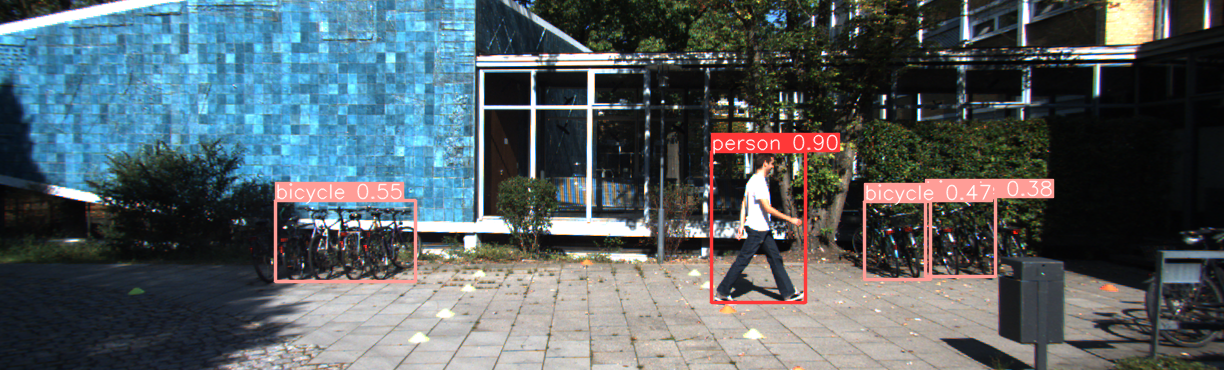

In [39]:
left_image = cv2.cvtColor(cv2.imread(left_image_paths[INDEX]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[INDEX]

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
imu_xyz = transform_uvz(uvz, T_cam_to_imu)


In [40]:
left_image.shape

(370, 1224, 3)

In [41]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

In [43]:
# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

In [50]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[INDEX]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);

## Scenario Drawing

In [51]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas

In [52]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf=12)
plt.imshow(canvas);

In [53]:
frame = np.hstack((stacked, 
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame);